In [469]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import gzip
%matplotlib inline
np.set_printoptions(suppress=True)

In [473]:
# state formulation:
# w, v, Cv, Tv, Cs, Ts, mu_s, mu_g, mu_ax, mu_ay
def initial_state(ye, psie, w, v, k, Cv, Tv, Cs, Ts, mu_s, mu_g, mu_ax, mu_ay):
    return np.float32([ye, psie, w, v, k, Cv, Tv, Cs, Ts, mu_s, mu_g, mu_ax, mu_ay])

#x = initial_state(0, 0, 0, 0, 0, 100, 1, 0.5, 0.5)
x = initial_state(5, -0.1, 0.01, 5, 0.01, 2, 0, -0.3, -0.3, 0, 0, 0, 0)

In [764]:
from numpy import exp, sin, cos, tan

def f(x, u, dt=1.0/30):
    ''' state prediction given input; returns new state and covariance '''
    ye, psie, w, v, k, Cv, Tv, Cs, Ts, mu_s, mu_g, mu_ax, mu_ay = x
    u_acceleration, u_steering = u
    
    eCv, eTv, eCs, eTs = exp(Cv), exp(Tv), exp(Cs), exp(Ts)

    x1 = np.float32([
            ye - dt*v * sin(psie),
            psie + dt*(w + v * k * cos(psie) / (1 - k * ye)),
            w + dt*(v*eCs*(u_steering - mu_s) - w) / eTs,  # fixme: this should be clipped at some traction limit
            v + dt*(eCv * u_acceleration - v) / eTv,
            k, Cv, Tv, Cs, Ts, mu_s, mu_g, mu_ax, mu_ay
        ])
    
    F = np.float32([
[1, -dt*v*cos(psie), 0, -dt*sin(psie), 0, 0, 0, 0, 0, 0, 0, 0, 0], [dt*k**2*v*cos(psie)/(k*ye - 1)**2, (dt*k*v*sin(psie) + k*ye - 1)/(k*ye - 1), dt, -dt*k*cos(psie)/(k*ye - 1), dt*v*cos(psie)/(k*ye - 1)**2, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, -dt*exp(-Ts) + 1, -dt*(mu_s - u_steering)*exp(Cs - Ts), 0, 0, 0, -dt*v*(mu_s - u_steering)*exp(Cs - Ts), dt*(v*(mu_s - u_steering)*exp(Cs) + w)*exp(-Ts), -dt*v*exp(Cs - Ts), 0, 0, 0], [0, 0, 0, -dt*exp(-Tv) + 1, 0, dt*u_acceleration*exp(Cv - Tv), dt*(-u_acceleration*exp(Cv) + v)*exp(-Tv), 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]        ])
    
    return x1, F

x[3] = 100  # give a velocity boost as nothing interesting happens at v=0
tx, tF = f(x, [0, 1])

In [765]:
def h_centerline(x):
    ''' return predicted centerline intercept and slope given state '''
    ye, psie, w, v, k, Cv, Tv, Cs, Ts, mu_s, mu_g, mu_ax, mu_ay = x
    hk = np.float32([ye / np.cos(psie), np.tan(psie)])
    Hk = np.float32([[1./cos(psie), ye*sin(psie)/cos(psie)**2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, cos(psie)**(-2), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
    return hk, Hk

h_centerline(x)

(array([-0.88472074,  0.26407698], dtype=float32),
 array([[-1.03428078, -0.2336344 ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.        ,  1.06973672,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ]], dtype=float32))

In [766]:
def h_imu(x, u):
    ''' return predicted IMU measurements from state '''
    ye, psie, w, v, k, Cv, Tv, Cs, Ts, mu_s, mu_g, mu_ax, mu_ay = x
    u_acceleration, u_steering = u
    
    # we need to steal the acceleration input here; this just shortcuts having an explicit
    # acceleration held in the state

    hk = np.float32([
            w + mu_g,
            v*w + mu_ax,
            -(exp(Cv) * u_acceleration - v) / exp(Tv) + mu_ay,
        ])
    Hk = np.float32([
            [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
            [0, 0, v, w, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, exp(-Tv), 0, -u_acceleration*exp(Cv - Tv), (u_acceleration*exp(Cv) - v)*exp(-Tv), 0, 0, 0, 0, 0, 1]
        ])
    return hk, Hk

h_imu(x, [0, 0])

(array([  -0.63187838, -689.18054199,    7.2599802 ], dtype=float32),
 array([[   0.        ,    0.        ,    1.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    1.        ,    0.        ,    0.        ],
        [   0.        ,    0.        ,  100.        ,   -6.95474291,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    1.        ,    0.        ],
        [   0.        ,    0.        ,    0.        ,    0.00966034,
            0.        ,    0.        ,   -0.96603382,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,    1.        ]], dtype=float32))

In [767]:
# 2480x2048 camera matrix -> 640x480 * 4 -> 320x240 * 8
camera_matrix = np.float32([
    [  1.13826615e+03,  0.00000000e+00,  1.31095665e+03],
    [  0.00000000e+00,  1.13236467e+03,  9.29698331e+02],
    [  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

dist_coeffs = np.float32([-0.01789552, 0, 0, 0])

# approximate scale conversion to cm
units_per_cm = 2.364 / 20.

camera_matrix[:2] /= 8.

new_camera_matrix = np.float32([
        [-20, 0, 160],
        [0, 20, 240],
        [0, 0, 1]
    ])

Rdown = cv2.Rodrigues(np.float32([-np.pi/2 - 0.075, 0, 0]))[0]
#Rdown = cv2.Rodrigues(np.float32([-0.075, 0, 0]))[0]
udm1, udm2 = cv2.fisheye.initUndistortRectifyMap(
    camera_matrix, dist_coeffs, Rdown, new_camera_matrix, (320, 240), cv2.CV_16SC2)
print udm1.shape, udm2.shape
# udm1, udm2 are reverse lookups: udm1[y, x] is the location of the pixel in the camera image
# which maps to x, y in the target image

# undistort_map is the forward lookup: undistort_map[y, x] contains the virtual pinhole camera
# coordinate of the real fisheye camera pixel x, y
undistort_map = cv2.fisheye.undistortPoints(
    np.mgrid[:320, :240].T.astype(np.float32),
    camera_matrix, dist_coeffs)

#undistort_map /= 20. / 2.4  # change unit length to cm


(240, 320, 2) (240, 320)


120
[-2.43728185  0.05662939]


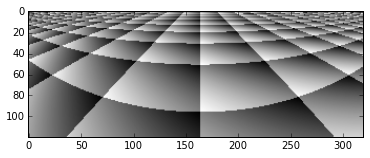

In [768]:
ytop = 120
print ytop
print undistort_map[ytop, 0]
udplane = np.dot(np.concatenate([undistort_map, np.ones((240, 320, 1))], axis=2), Rdown.T)[ytop:]

udplane[:, :, 0] /= udplane[:, :, 2]
udplane[:, :, 1] /= udplane[:, :, 2]
#udplane[:, :, :2] *= 10
plt.imshow((udplane[:, :, 0]%1) + (udplane[:, :, 1]%1), 'gray')
np.savetxt("udplane.txt", udplane[:, :, :2].reshape(-1), newline=",\n")


In [769]:
udm1, udm2 = cv2.fisheye.initUndistortRectifyMap(
    camera_matrix, dist_coeffs, Rdown, new_camera_matrix, (320, 240), cv2.CV_16SC2)
print udm1.shape, udm2.shape


(240, 320, 2) (240, 320)


In [918]:
def kalman_update_input(x0, P, u, dt):
    x, Fk_1 = f(x0, controls, dt)
    print >>kalman_log, 'f', x0[:4], '->', x[:4]
    #Q = np.diag([v*dt*0.001, v*dt*0.00001, v*dt*0.001, dt*0.1, v*dt*0.01, 0, 0, 0, 0])**2  # process noise
    
    v = 0.5 + np.abs(x[3])  # use velocity to determine process noise magnitudes
    Qk_1 = np.diag([  # process noise
            v*dt*0.1,  # ye shouldn't jitter much at all
            v*dt*0.01,  # neither should psie
            v*dt*0.2,  # angular steering should mostly be correct from controls but give it slack
            dt*0.001,   # same with velocity
            v*dt*0.001,  # curvature can change nearly instantaneously, but its scale is tiny
            1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4])  # the remainder are undetermined constants
    # print >>kalman_log, 'Q', np.diag(Qk_1)
    
    # print >>kalman_log, 'F\n', Fk_1
    P = np.dot(Fk_1, np.dot(P, Fk_1.T)) + Qk_1
    # print >>kalman_log, 'Qk\n', Qk_1
    # print >>kalman_log, 'predict P\n', P

    return x, P
   

In [1000]:
def kalman_update_cam(img, x, P, mask, dt):
    N = len(nz[0])
    if N < 20:
        return x, P

    # measure line slope / position
    nzt = udplane[(nz[0], nz[1])]  # undistort coordinates
    X = np.vstack([np.ones(N), nzt[:,1]]).T  # 1, screen y is X
    y = nzt[:,0]   # screen x coords are y in our regression
    B = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, y))
    r2 = np.dot(B.T, np.dot(np.dot(X.T, X), B)) - 2*np.dot(np.dot(X, B).T, y) + np.dot(y.T, y)
    # r2 /= N
    Rk = np.linalg.inv(np.dot(X.T, X)) * r2
    Rk[1, 1] += 0.01  # slope is just iffy in general
    pts = np.float32([[B[0], 0, 1], [B[0]-10*B[1], -10, 1]]).T
    p = np.dot(new_camera_matrix, pts)
    # draw instantaneous line fit
    cv2.line(img, (int(p[0, 0]), int(p[1, 0])),
             (int(p[0, 1]), int(p[1, 1])),
             (255, 255, 255))
    cv2.putText(img, "b%0.3f m%0.3f r%0.4f" % (B[0], B[1], r2), (0, 239), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

    # kalman update from line parameters B
    z_k, H_k = h_centerline(x)    
    y_k = (B - z_k)
    S = np.dot(H_k, np.dot(P, H_k.T)) + Rk
    K = np.dot(P, np.dot(H_k.T, np.linalg.inv(S)))
    print >>kalman_log, 'mb_K\n', K
    print >>kalman_log, 'y_k', y_k, 'pred', z_k, 'meas', B
    #print 'K[0]', K[:, 0]
    #print 'K[1]', K[:, 1]
    x += np.dot(K, y_k)

    KHk = np.dot(K, H_k)
    P = np.dot((np.eye(len(x)) - KHk), P)
    # print x[:4]
    # print np.diag(P)[:4]
    
    return x, P


In [1001]:
def kalman_update_imu(x, P, u, accel, gyro, dt):
    z_k, H_k = h_imu(x, u)
    # convert accelerometer gs to cm/s^2
    accel = 980 * units_per_cm * accel
    y_k = np.float32([gyro[2], accel[0], accel[1]]) - z_k

    # accelerometer measurements are hugely noisy, almost not even worth it
    Rk = np.diag([1e-2, units_per_cm*200, units_per_cm*200])**2  # measure the actual noise?
    
    S = np.dot(H_k, np.dot(P, H_k.T)) + Rk
    K = np.dot(P, np.dot(H_k.T, np.linalg.inv(S)))
    print >>kalman_log, 'imu K\n', K
    print >>kalman_log, 'imu y_k', y_k, 'pred', z_k, 'meas', y_k + z_k
    x += np.dot(K, y_k)

    KHk = np.dot(K, H_k)
    P = np.dot((np.eye(len(x)) - KHk), P)

    return x, P


In [1036]:
capture = open("home05-13-10-0.yuv")  # gzip.open("driveway4-1.yuv.gz")

x = initial_state(0, 0, 0, 0, 0, np.log(10), 0, np.log(0.3), np.log(0.5), 0, 0, 0, 0)
P = np.diag([5, 1, 0.1, 0.1, 0.01, 1, 0.1, 0.1, 0.1, 0.1, 0.01, 0.01, 0.01])**2

write_video = False

if write_video:
    out = cv2.VideoWriter("ekf.h264", cv2.VideoWriter_fourcc(
          'X', '2', '6', '4'), 30, (640, 480), True)

kalman_log = open("kalman.log", "w")
    
prev_ts = None
while True:
    fhdr = 36
    fsize = fhdr + 640*480 + 320*240*2
    frame = np.frombuffer(capture.read(fsize), np.uint8)
    if len(frame) < fsize:
        break
    tstamp = np.frombuffer(np.getbuffer(frame[:8]), np.uint32)
    controls = np.frombuffer(np.getbuffer(frame[8:12]), np.uint16)
    accel = np.frombuffer(np.getbuffer(frame[12:24]), np.float32)
    gyro = np.frombuffer(np.getbuffer(frame[24:36]), np.float32)
    # FIXME: bug workaround: gyro full scale was off by a factor of 4
    # gyro = gyro * 4.0   # not needed with driveway4+
    ts = tstamp[0] + tstamp[1] / 1000000.0

    # hack because i forgot to save autodrive throttle
    # if controls[0] == 614 and controls[1] != 655:
    #     controls = [700, controls[1]]
    controls = np.float32(controls) / 204.8 - 3.0
    # controls[1] = controls[1] - 6500/32768.0  # steering is backwards and has a trim value of ~6500
    # but we want backwards steering as we have w as counterclockwise

    y = frame[fhdr:fhdr+640*480]
    u = frame[fhdr+640*480:fhdr+640*480+320*240]
    v = frame[fhdr+640*480+320*240:]
    img = cv2.cvtColor(frame[fhdr:].reshape((-1, 640)), cv2.COLOR_YUV420P2RGB)
    
    mask = ((u[ytop*320:] < U_THRESH) & (v[ytop*320:] > V_THRESH)).reshape(-1, 320)
    nz = np.nonzero(mask)
    
    img[2*ytop+nz[0]*2, nz[1]*2, 0] = 255
    img[2*ytop+nz[0]*2, nz[1]*2, 1] = 255
    img[2*ytop+nz[0]*2, nz[1]*2, 2] = 0
    #img[mask, 2] = 255
    
    birdseye = cv2.remap(img[::2,::2], udm1, udm2, cv2.INTER_LINEAR)  #, borderMode=cv2.BORDER_CONSTANT, borderValue=(255,255,255))

    img[:240, :320] = birdseye
    
    dt = 1.0/30
    if prev_ts is not None:
        dt = ts - prev_ts
    prev_ts = ts

    x, P = kalman_update_input(x, P, controls, dt)
    
    x, P = kalman_update_cam(img, x, P, nz, dt)
    
    x, P = kalman_update_imu(x, P, controls, accel, gyro, dt)
    
    # if psi went backwards, fix it... or don't, cuz we're going backwards i guess?
    if x[1] > np.pi / 2:
        x[1] -= np.pi
    elif x[1] < -np.pi / 2:
        x[1] += np.pi
    x[3] = np.abs(x[3])  # (v) dumb hack: keep us from going backwards when we're confused
    x[4] = np.clip(x[4], -0.3, 0.3)

    print >>kalman_log, 'x', x
    print >>kalman_log, 'P', np.diag(P)
    kalman_log.flush()
    
    # plot new line with measurement from kalman state
    B, _ = h_centerline(x)
    pts = np.float32([[B[0], 0, 1], [B[0]-10*B[1], -10, 1]]).T
    p = np.dot(new_camera_matrix, pts)
    # draw kalman line fit
    cv2.line(img, (int(p[0, 0]), int(p[1, 0])),
             (int(p[0, 1]), int(p[1, 1])),
             (0, 255, 0))
    
    # plot circle of assumed curvature
    # center is at
    if x[4] != 0:
        t = np.linspace(0, 10, 10)
        r = 1.0/x[4]

        # cos(a+b) = cosa cosb - sina sinb
        # cos(x1)*cos(x4*t)/x4 - sin(x1)*sin(x4*t)/x4 - cos(x1)
        # cos(x1)*(cos(x4*t) - 1)/x4 - sin(x1)*sin(x4*t)/x4
        # ^ more numerically stable when x4 is nearly zero
        
        # sin(a+b) = sina cosb + cosa sinb
        # sin(x1) - sin(x1 - x4*t)
        # sin(x1) - sin(x1) cos(x4*t) - cos(x1) sin(x4*t)
        # sin(x1)*(1 - cos(x4*t)) - cos(x1) sin(x4*t)
                
        pts = np.vstack([
                #r*(np.cos(x[1] + x[4]*t) - np.cos(x[1])) + x[0],
                r*(np.cos(x[1])*(np.cos(x[4]*t) - 1) - np.sin(x[1])*np.sin(x[4]*t)) + x[0],
                #r*(-np.sin(x[1] + x[4]*t) + np.sin(x[1])),
                r*(np.sin(x[1])*(1 - np.cos(x[4]*t)) - np.cos(x[1])*np.sin(x[4]*t)),
                np.ones(10)])
        p = np.dot(new_camera_matrix, pts)
        for i in range(0, 9):
            cv2.line(img, (int(p[0, i]), int(p[1, i])),
                     (int(p[0, i+1]), int(p[1, i+1])),
                     (255, 255, 0))
    
    # draw projection of predicted velocity
    
    # draw a five-frame prediction
    pts = np.float32([[0, -1, 1],
                      [5*dt*x[3]*np.sin(5*dt*x[2]),
                       -1 - 5*dt*x[3]*np.cos(5*dt*x[2]), 1]]).T
    p = np.dot(new_camera_matrix, pts)
    cv2.line(img, (int(p[0, 0]), int(p[1, 0])),
             (int(p[0, 1]), int(p[1, 1])),
             (0, 0, 255))

    cv2.putText(img, "y%0.2f psi%0.2f w%0.2f v%0.2f k%0.2f" % tuple(x[:5]), (0, 270),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)

    cv2.putText(img, "Cv%0.2f Tv%0.2f Cs%0.2f Ts%0.2f" % tuple(np.exp(x[5:9])), (0, 290),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)
    
    cv2.putText(img, "a%0.2f s%0.2f" % tuple(controls), (0, 310),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)

    cv2.putText(img, "us%0.4f ug%0.4f uax%0.4f uay%0.4f" % tuple(x[9:13]), (0, 330),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)
    
    # show ytop
    cv2.line(img, (0, ytop*2), (640, ytop*2), (0,0,0), 1)
    
    # show controls
    cv2.line(img, (320, 470), (int(320 + 300*controls[0]), 470), (0,0,0), 4)
    cv2.line(img, (320, 470), (int(320 + 300*controls[0]), 470), (255,255,255), 2)
    cv2.line(img, (320, 475), (int(320 + 300*controls[1]), 475), (0,0,0), 4)
    cv2.line(img, (320, 475), (int(320 + 300*controls[1]), 475), (255,255,255), 2)
    # show accelerometer measurement
    cv2.line(img, (50, 440), (int(50 + 10*accel[0]), int(440 - 100*accel[1])), (0,0,0), 4)
    cv2.line(img, (50, 440), (int(50 + 10*accel[0]), int(440 - 100*accel[1])), (0,255,255), 2)
    # show gyro
    cv2.line(img, (320, 460), (int(320 + 320*gyro[2]), 460), (0,0,0), 4)
    cv2.line(img, (320, 460), (int(320 + 320*gyro[2]), 460), (255,255,0), 2)


    cv2.imshow('f', img)
    if write_video:
        out.write(img)
        
    if cv2.waitKey() == ord('q'):
        break

if write_video:
    del out

cv2.destroyAllWindows()
cv2.waitKey(1)

kalman_log.close()
del kalman_log

In [1029]:
U_THRESH = 112
V_THRESH = 0

In [897]:
x = initial_state(0, 0, 0, 0, 0, np.log(10), 0, np.log(0.3), np.log(0.5), 0, 0, 0, 0)
P = np.diag([5, 1, 0.1, 0.1, 0.01, 1, 0.1, 0.1, 0.1, 0.1, 0.01, 0.01, 0.01])**2

x, P = kalman_update_input(x, P, [1, 1], 1.0/30)
print x
print P

NameError: global name 'kalman_log' is not defined